In [39]:
!nvidia-smi

Wed Jun 15 11:52:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 23%   24C    P8    15W / 250W |  10912MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 23%   

In [40]:
from jarvis.utils.general import gpus

gpus.autoselect()

[ 2022-06-15 11:52:01 ] CUDA_VISIBLE_DEVICES already manually set to: 0        


In [41]:
import numpy as np
from jarvis.train import datasets
from jarvis.utils.display import imshow
from tensorflow.keras import Input
from jarvis.train.client import Client

from IPython.display import clear_output
import matplotlib.pyplot as plt
import tensorflow as tf

In [42]:
def show_mri(mri):
    for i in range(mri.shape[0]):
        clear_output(wait=True)
        plt.axis(False)
        plt.imshow(mri[i, :, :, 0], cmap='gray')
        plt.show()

In [43]:
# --- prepare generators
client = Client('/data/raw/miccai_rsna/data/ymls/client-3d.yml')
gen_train, gen_valid = client.create_generators()

In [44]:
# --- Show a sample training set
xs, ys = next(gen_train)
# imshow(xs['t2w'][0][24], radius=1)
print(ys['lbl'][0])

[[[[0]]]]


In [45]:
flair = xs['fla']
flair.shape

(4, 48, 96, 96, 1)

In [46]:
flair1 = flair[0]

In [47]:
flair1.shape

(48, 96, 96, 1)

In [48]:
np.min(flair1)

-0.8152425315355885

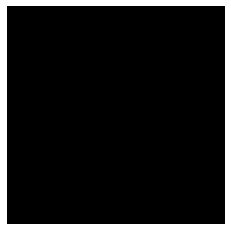

In [49]:
show_mri(flair[1])

In [50]:
ys

{'lbl': array([[[[[0]]]],
 
 
 
        [[[[0]]]],
 
 
 
        [[[[0]]]],
 
 
 
        [[[[1]]]]], dtype=uint8)}

In [51]:
ys['lbl'][:, 0, 0, 0]

array([[0],
       [0],
       [0],
       [1]], dtype=uint8)

In [52]:
xs.keys()

dict_keys(['t2w', 't1w', 't1wce', 'fla', 'lbl'])

In [53]:
# --- Print keys 
for key, arr in xs.items():
    print('xs key: {} | shape = {}'.format(key.ljust(8), arr.shape))

xs key: t2w      | shape = (4, 48, 96, 96, 1)
xs key: t1w      | shape = (4, 48, 96, 96, 1)
xs key: t1wce    | shape = (4, 48, 96, 96, 1)
xs key: fla      | shape = (4, 48, 96, 96, 1)
xs key: lbl      | shape = (4, 1, 1, 1, 1)


In [54]:
# --- Create model inputs
inputs = client.get_inputs(Input)

In [55]:
inputs

{'t2w': <KerasTensor: shape=(None, 48, 96, 96, 1) dtype=float32 (created by layer 't2w')>,
 't1w': <KerasTensor: shape=(None, 48, 96, 96, 1) dtype=float32 (created by layer 't1w')>,
 't1wce': <KerasTensor: shape=(None, 48, 96, 96, 1) dtype=float32 (created by layer 't1wce')>,
 'fla': <KerasTensor: shape=(None, 48, 96, 96, 1) dtype=float32 (created by layer 'fla')>,
 'lbl': <KerasTensor: shape=(None, 1, 1, 1, 1) dtype=uint8 (created by layer 'lbl')>}

In [56]:
from tensorflow.keras.layers import Dense, Conv3D, GlobalAveragePooling3D, Flatten, InputLayer, MaxPool3D

In [161]:
base_model = tf.keras.Sequential()
base_model.add(InputLayer(input_shape=(48, 96, 96, 1)))
base_model.add(Conv3D(16, 3, activation='relu', padding='same', data_format='channels_first'))
base_model.add(MaxPool3D(padding='same', data_format='channels_first'))
base_model.add(Conv3D(32, 3, activation='relu', padding='same', data_format='channels_first'))
base_model.add(MaxPool3D(padding='same', data_format='channels_first'))
base_model.add(Conv3D(48, 3, activation='relu', padding='same', data_format='channels_first'))
base_model.add(MaxPool3D(padding='same', data_format='channels_first'))
# base_model.add(Conv3D(64, 3, activation='relu', padding='same', data_format='channels_first'))
# base_model.add(MaxPool3D(padding='same', data_format='channels_first'))
# base_model.add(Conv3D(80, 3, activation='relu', padding='same', data_format='channels_first'))
# base_model.add(MaxPool3D(padding='same', data_format='channels_first'))

base_model.add(Flatten())
base_model.add(Dense(128, activation='relu'))
base_model.add(Dense(1, activation='sigmoid'))


In [162]:
base_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_23 (Conv3D)           (None, 16, 96, 96, 1)     20752     
_________________________________________________________________
conv3d_24 (Conv3D)           (None, 32, 96, 96, 1)     13856     
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 48, 96, 96, 1)     41520     
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 64, 96, 96, 1)     83008     
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 80, 96, 96, 1)     138320    
_________________________________________________________________
flatten_2 (Flatten)          (None, 737280)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)              

In [163]:
from tensorflow.keras.losses import BinaryCrossentropy

In [164]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
bce = BinaryCrossentropy()
# @tf.function
def train_step(x, y):
#     print(y.shape)
    with tf.GradientTape() as tape:
#         print('beginning training...')
        y_hat = base_model(x, training=True)
#         print(y_hat.shape)
#         print('done training...')
        loss = bce(y, y_hat)
    grads = tape.gradient(loss, base_model.trainable_variables)
    opt.apply_gradients(zip(grads, base_model.trainable_variables))
    return loss

In [165]:
annoying_case = None
annoying_case_unproc = None

In [166]:
def train(train_dataset, n_epochs=1, max_steps_per_epoch=None):
    global annoying_case, annoying_case_unproc
    for epoch in range(n_epochs):
        for i, batch in enumerate(train_dataset):
            xs, ys = batch
            print(xs['fla'].shape)
            fla = xs['fla']
            x_prep = fla # (fla-np.min(fla))/(np.max(fla)-np.min(fla))
            if max_steps_per_epoch is not None:
                if i == max_steps_per_epoch:
                    break
#             adversarial = (epoch >= 1)
            if(np.isnan(x_prep).any()):
                continue
            l1 = train_step(x_prep, ys['lbl'].reshape(4, 1))#[:, 0, 0, 0])
#             del batch
            clear_output(wait=True)
            if np.isnan(np.max(x_prep)) or np.isnan(np.min(x_prep)):
                annoying_case = x_prep
                annoying_case_unproc = fla
#             show_mri(x_prep[0])
            print("Epoch {}/{}".format(epoch + 1, n_epochs))
            print(f'Step {i+1}')
#             print(f'MRI Shape: {x_prep.shape}')
#             print(f'Max Flair: {np.max(x_prep)}')
#             print(f'Min Flair: {np.min(x_prep)}')
            print(f'Loss: {round(l1.numpy(), 2)}')
            

In [167]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [168]:
# --- prepare generators
client = Client('/data/raw/miccai_rsna/data/ymls/client-3d.yml')
gen_train, gen_valid = client.create_generators()
train(gen_train, max_steps_per_epoch=100, n_epochs=1)

Epoch 1/1
Step 100
Loss: 0.6700000166893005
(4, 48, 96, 96, 1)


In [169]:
NUM_VAL_SCANS = 100

In [170]:
preds = []
labels = []
for i, batch in enumerate(gen_valid):
    xs, ys = batch
    pred = base_model.predict(xs['fla'])
    y = ys['lbl']
    labels.append(y.reshape(4, 1))
    preds.append(pred)
    if i == NUM_VAL_SCANS:
        break

In [171]:
preds = np.array(preds).reshape(-1,)
labels = np.array(labels).reshape(-1,)

In [172]:
preds

array([0.52749956, 0.52749956, 0.52749956, 0.52749956, 0.52749956,
       0.52749956, 0.52749956, 0.52749956, 0.52749956, 0.52749956,
       0.52749956, 0.52749956, 0.52749956, 0.52749956, 0.52749956,
       0.52749956, 0.52749956, 0.52749956, 0.52749956, 0.52749956,
       0.52749956, 0.52749956, 0.52749956, 0.52749956, 0.52749956,
       0.52749956, 0.52749956, 0.52749956, 0.52749956, 0.52749956,
       0.52749956, 0.52749956, 0.52749956, 0.52749956, 0.52749956,
       0.52749956, 0.52749956, 0.52749956, 0.52749956, 0.52749956,
       0.52749956, 0.52749956, 0.52749956, 0.52749956, 0.52749956,
       0.52749956, 0.52749956, 0.52749956, 0.52749956, 0.52749956,
       0.52749956, 0.52749956, 0.52749956, 0.52749956, 0.52749956,
       0.52749956, 0.52749956, 0.52749956, 0.52749956, 0.52749956,
       0.52749956, 0.52749956, 0.52749956, 0.52749956, 0.52749956,
       0.52749956, 0.52749956, 0.52749956, 0.52749956, 0.52749956,
       0.52749956, 0.52749956, 0.52749956, 0.52749956, 0.52749

In [173]:
preds[preds > 0.5] = 1
preds[preds <= 0.5] = 0

In [174]:
from sklearn.metrics import accuracy_score

In [175]:
acc = accuracy_score(preds, labels)
print(f'Validated on {NUM_VAL_SCANS} scans...')
print(f'Accuracy: {acc}')

Validated on 100 scans...
Accuracy: 0.4900990099009901
